
# <center>QISKit hands on lab addition : Grover with circuits and Aqua</center>

### <span style="color:blue"><em>Jean-Michel Torres, IBM Q Hub France, torresjm@fr.ibm.com</em></span>


### Agenda :
<ol>
    <li>What is Grover search algorithm</li>
    <li>Tiny sample coding Grover operator</li>
    <li>Using QISKit AQUA for 3SAT with Grover</li>
</ol>


<div class="alert alert-block alert-success">
    
#  A. Grover search algorithm
</div>

Grover search alogrithm finds an element from a non ordered set, faster than any classical algorithm.

In other words Grover search algorithm will find an element matching a criteria, out of an unordered list.

<img src="./images/long_list.jpg" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="600 px" align="center">
<br>

Let's apply to the very tiny example of finding one element out of four, and to relate to an example : let's find where is the Queen of Hearts out of four Queen.
This is equivalent to find what index in the list is set to 1 (when others are set to 0).

Classical process requires an average of 2.25 tries to find the index value of one element out of four (i.e: find the Queen of hearts hidden amongst four Queen). 


| draw     | Probability p of finding QH | Quantity q of draw(s) | p x q  |
| ----------- | ------------- |-----------------------------------------------| --- |
|First | 0.25| 1 | 0.25 |
|Second | 0.25  | 2 | 0.5 |
|Third (1)| 0.5  | 3 | 1.5 |
|TOTAL   | - |- |2.25|
  
(1) At this point, wether we draw the Queen of Hearts or not, we know where it is, so this is the final draw, no need for the 4rth draw.

On the other hand, in this case, Grover search algorithm can find the Queen of hearts in a single attempt. 

More generally Grover search algorithm will require a number of attempts proportionnal to square root of N, where N is the set size:

\begin{equation} 
\frac{\pi}{4}{\sqrt{N}} 
\end{equation}


In [1]:
# Classical way: hiding one card at a random position, and then count the attempts before the card is found.
from random import randint

def hide(n):
    ''' this creates a list of n '0', with one '1' at a random position'''
    cards = [0 for i in range(n)]  # only 0'
    position = randint(0, n-1)     # draw a random position
    cards[position] = 1            # this position now has a 1 (others keep 0)
    return cards
    
def find(cards): 
    n = 0 # initialize attempts needed to find the hidden position
    while len(cards) > 1: # when there is one card left, we know it is the hidden position
        trial = randint(0,len(cards)-1) # try one position at random
        if cards[trial]: 
            n+=1
            break
        else:
            n+=1
            # remove that card from the list
            cards = cards[0:trial] + cards[trial+1:len(cards)]
    return n

# params : lentgh = number of cards face down in the game,
#          could be 4, 32, or any
# params : draws = quantity of times the experience will
#          be made to be able to calculate the average draws 
#          needed to find the hidden position
length = 4
draws = 1000

# initalize count of shots needed to find hidden position
shots = 0
for d in range(draws):
    cards = hide(length)
    shots += find(cards) 

print(f"With {length} cards and {draws} experiments:")
print(f"    the hidden card was found in a average of {shots/draws} draws")

With 4 cards and 1000 experiments:
    the hidden card was found in a average of 2.249 draws



So now, let's go with the quantum computing demo with N=4 (4 cards, 4 positions) 


<div class="alert alert-block alert-success">
    
#  B. Grover search algorithm with QISKit circuits
</div>

## 1. SETUP

### General setup


The cell below imports the needed function from qiskit and other libraries:


In [2]:
from IPython.display import Image, display
from random import randint
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute

print("The required objects have been imported from QISKit and other Python libraries")

The required objects have been imported from QISKit and other Python libraries


### Defining the sub functions for setting the index as data entry

We are defining 4 custom gates (need QISKit version 0.9 and above)

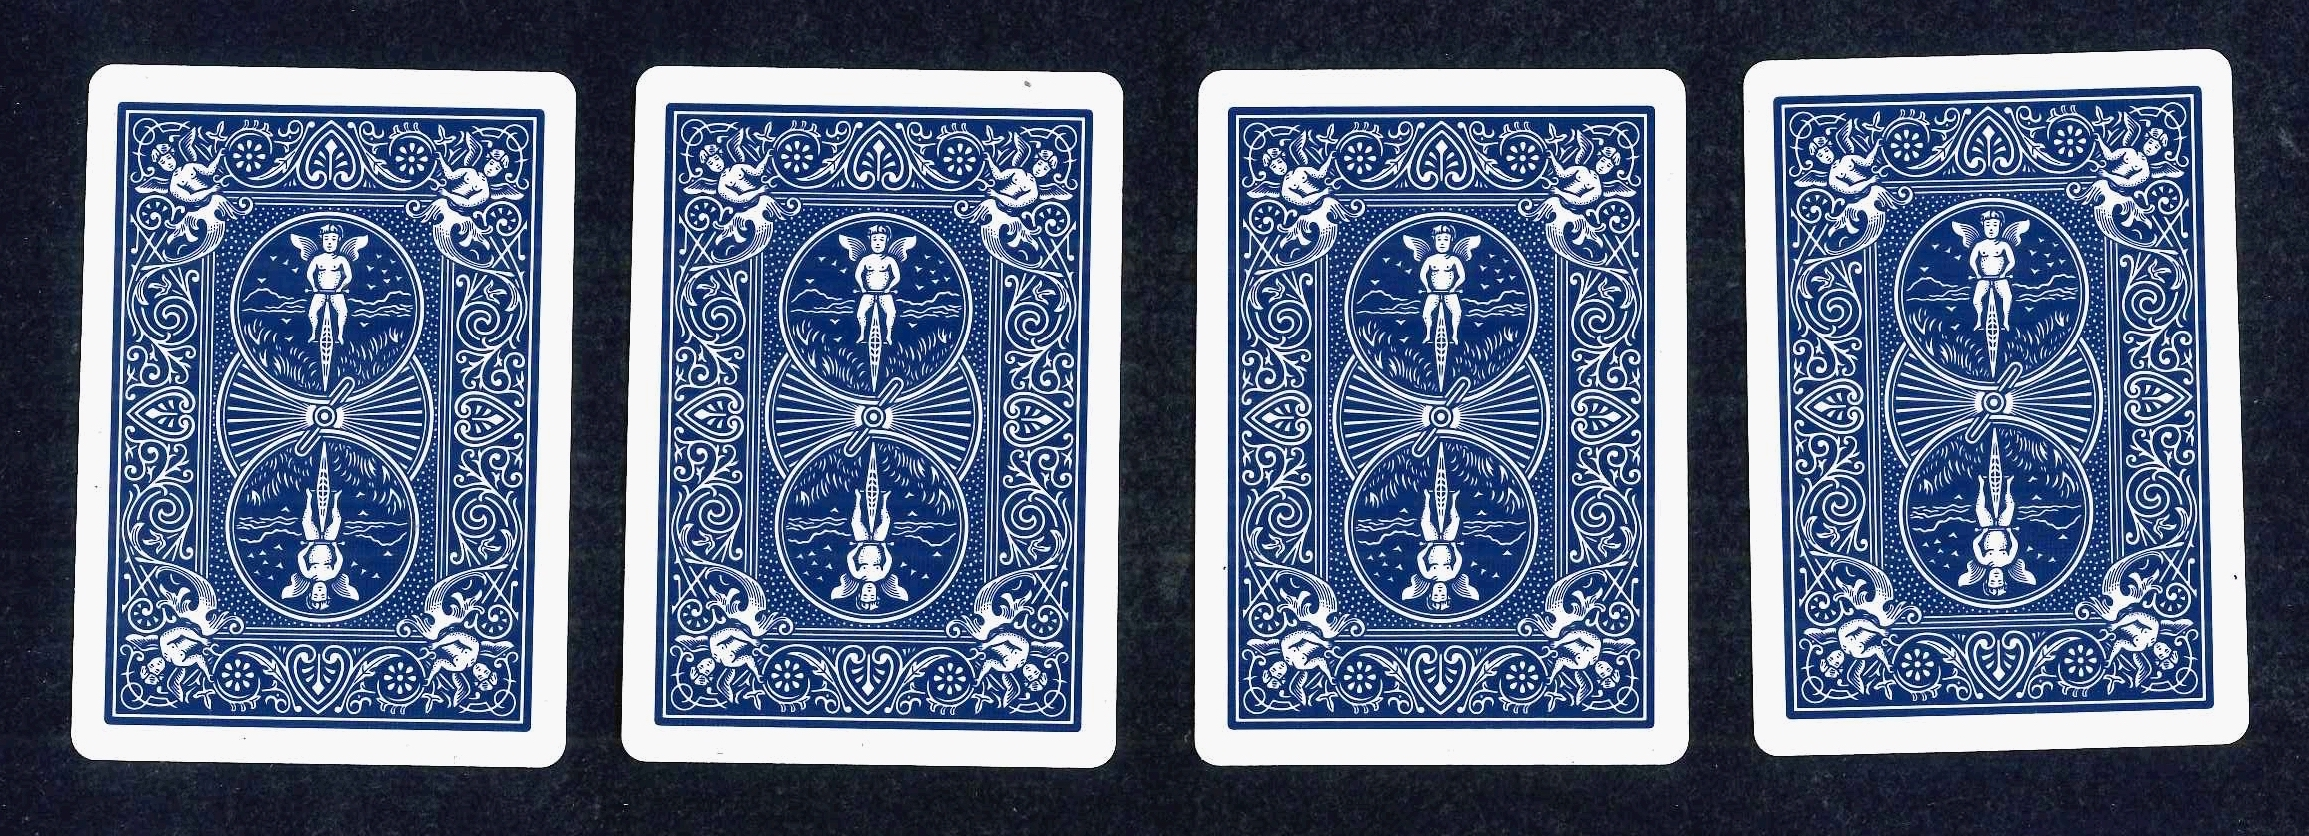

We have created our own quantum gates,
to prepare the state of our QH hidden in any of the four positions


In [3]:
sub_qr = QuantumRegister(2)

# let's define a list of custom gates, there will be four of them, each one to "hide"
# the card in of of the four possible positions 
hide = []
# this dummy circuit is just to fill position 0 in the list, so we do not get confused
# later witn an ofsset between position and index. 
dummy = QuantumCircuit(1)
hide.append(dummy)

# first position 
sub_circ = QuantumCircuit(sub_qr, name='Hide')
for i in range(2):
    sub_circ.h(sub_qr[i])
    sub_circ.s(sub_qr[i])
sub_circ.h(sub_qr[1])
sub_circ.cx(sub_qr[0], sub_qr[1])
sub_circ.h(sub_qr[1])
for i in range(2):
    sub_circ.s(sub_qr[i])
# Convert to a gate
hide.append(sub_circ.to_instruction())

# second position 
sub_circ = QuantumCircuit(sub_qr, name='Hide')
for i in range(2):
    sub_circ.h(sub_qr[i])
sub_circ.s(sub_qr[1])
sub_circ.h(sub_qr[1])
sub_circ.cx(sub_qr[0], sub_qr[1])
sub_circ.h(sub_qr[1])
sub_circ.s(sub_qr[1])
# Convert to a gate
hide.append(sub_circ.to_instruction())

# third position 
sub_circ = QuantumCircuit(sub_qr, name='Hide')
sub_circ.h(sub_qr[0])
sub_circ.h(sub_qr[1])
sub_circ.s(sub_qr[0])
sub_circ.h(sub_qr[1])
sub_circ.cx(sub_qr[0], sub_qr[1])
sub_circ.h(sub_qr[1])
sub_circ.s(sub_qr[0])
# Convert to a gate
hide.append(sub_circ.to_instruction())

# fourth position 
sub_circ = QuantumCircuit(sub_qr, name='Hide')
sub_circ.h(sub_qr[0])
sub_circ.h(sub_qr[1])
sub_circ.h(sub_qr[1])
sub_circ.cx(sub_qr[0], sub_qr[1])
sub_circ.h(sub_qr[1])
# Convert to a gate
hide.append(sub_circ.to_instruction())

display(Image(filename='./images/cards/4FacesDown.jpeg', width=800))

print("We have created our own quantum gates,")
print("to prepare the state of our QH hidden in any of the four positions")

# uncomment next lines to visualize
#q = QuantumRegister(2, 'q')
#circ = QuantumCircuit(q)
#for i in range(4): 
#circ.append(hide[i], [q[0], q[1]])
#circ.draw(output='mpl')


### Building the Grover operator, this sub function will be used to reveal the hidden index in one shot

We have created our Grover operator on 2 qubits
 
We are ready to go !


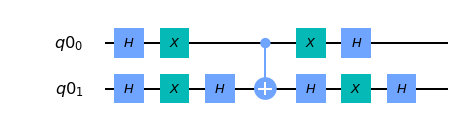

In [4]:
# Grover operator 
sub_circ = QuantumCircuit(sub_qr, name='Grover-Op')
for i in range(2):
    sub_circ.h(sub_qr[i])
    sub_circ.x(sub_qr[i])
sub_circ.h(sub_qr[1])
sub_circ.cx(sub_qr[0], sub_qr[1])
sub_circ.h(sub_qr[1])
for i in range(2):
    sub_circ.x(sub_qr[i])
    sub_circ.h(sub_qr[i])

# Convert to a gate
grover = sub_circ.to_instruction()

print("We have created our Grover operator on 2 qubits")
print(" ")
print("We are ready to go !")

# uncomment next lines to visualize
q = QuantumRegister(2, 'q')
circ = QuantumCircuit(q)
circ.append(grover, [q[0], q[1]])
circ.draw(output='mpl')
sub_circ.draw(output="mpl")

## 2. DRAW A RANDOM POSITION

### ... and keep it secret. 

In [5]:
secret = randint(1,4)

print("Now, the secret position has been chosen, no one knows what it is,")
print(" ")
print("Let's first use Grover to find it !")

Now, the secret position has been chosen, no one knows what it is,
 
Let's first use Grover to find it !


## 3. Now build the circuit: 

### adding the chosen sub circuit (at random) and the grover operator, then measurement step. 


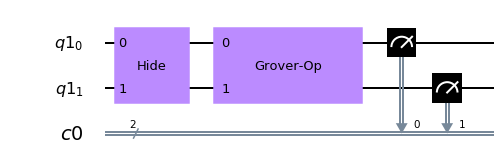

In [6]:
# define needed registers, and our quantum circuit. 
qr = QuantumRegister(2)    
cr = ClassicalRegister(2)

circ = QuantumCircuit(qr,cr)

# use the selected hide gate (determined by random value "secret")
circ.append(hide[secret], [qr[0],qr[1]])
# add grover operator
circ.append(grover, [qr[0],qr[1]])
# add measuring stage
circ.measure(qr,cr)
# that's it !
circ.draw(output='mpl')

## 4. Execute the circuit (on the local simulator) : 

- choose backend

- define job

- get result

In [7]:
from qiskit import Aer
#print(Aer.backends())
backend = Aer.get_backend('qasm_simulator')
# define job, get results
job = execute(circ,backend,shots=100)
my_result = job.result()
d = (my_result.get_counts(circ))

max = 0
for x in d:
    if d[x] > max:
        val = x

if val == '00': 
    position = "first"
if val == '10':
    position = "second"
if val == '01': 
    position = "third"
if val == '11': 
    position = "fourth"
    
print(" ")
print("The position found by Grover search algorithm is:", position)


 
The position found by Grover search algorithm is: fourth


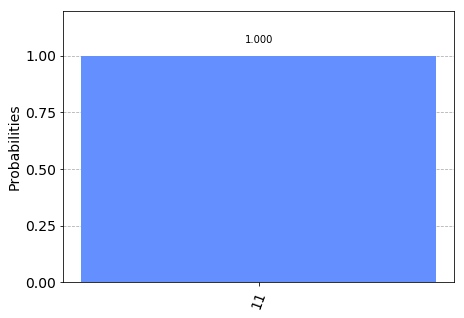

In [8]:
from qiskit.tools.visualization import plot_histogram
# define job, get results
job = execute(circ,backend,shots=100)
my_result = job.result()
d = (my_result.get_counts(circ))

plot_histogram(my_result.get_counts(circ))

## 5. Reveal what was the hidden position (the index of the data element searched)

The hiding position was: 4
Grover search needed to turn only one card to discover the queen of Hearts: 


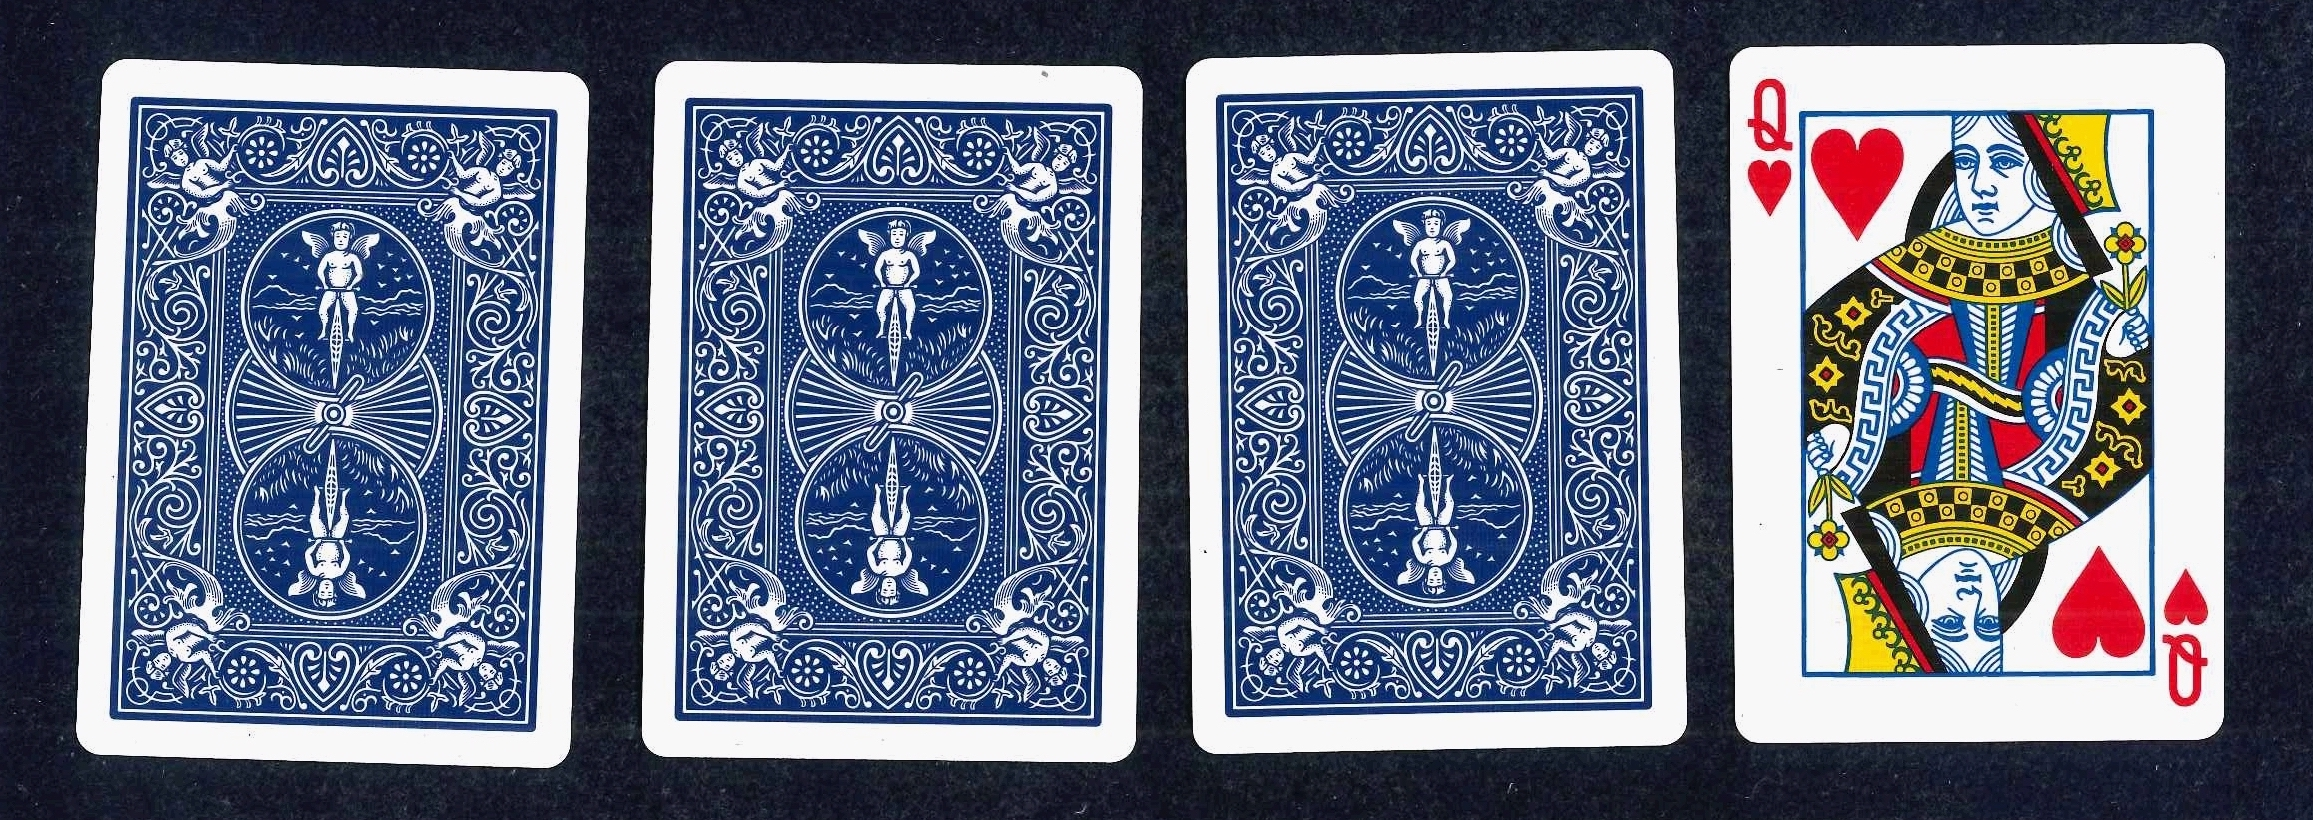

In [9]:
print(f"The hiding position was: {secret}")
print("Grover search needed to turn only one card to discover the queen of Hearts: ")

filename = './images/cards/QHFaceUPPos'+str(secret)+'.jpeg'

display(Image(filename=filename, width=800))


## You can also run this on a real backend using IBMQ. 

<div class="alert alert-block alert-success">
    
#  C.  QISKit AQUA for 3SAT with Grover
</div>

In [10]:
import pylab
import numpy as np
from qiskit import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.aqua import QuantumInstance
from qiskit.aqua import run_algorithm
from qiskit.aqua.algorithms import Grover
from qiskit.aqua.components.oracles import LogicalExpressionOracle, TruthTableOracle

Again, let's search for a card in a deck. 
This time, within a 32 cards deck (7,8,9,10,J,Q,K,A,Spades,Hearts,Diamonds,Clubs). 
Let's use these booleans to catagorize the cards: 
<ul>
    <li>$x_1$ : the card is a number (7,8,9,10)</li>
    <li>$x_2$ : the card is red (hearts, diamonds)</li>
    <li>$x_3$ : the suit has a sharp edge on top (spades, diamonds)</li>
    <li>$x_4$ : the card is at odd position (7,9,J,K)</li>
    <li>$x_5$ : the card is in the middle values (9,10,J,Q)</li>
</ul>

With this we can form a logical expression, in the 3SAT form: 

$F = ( x_1 \lor x_2 \lor x_5) \land ( x_1 \lor  x_2 \lor \neg x_5) \land ( x_1 \lor \neg x_2 \lor x_5) \land ( \neg x_1 \lor  x_2 \lor  x_5) \land ( \neg x_1 \lor  x_2 \lor \neg x_5) ...$

$... ( \neg x_1 \lor \neg x_2 \lor x_4) \land (\neg x_2 \lor \neg x_3 \lor x_4) \land ( \neg x_2 \lor \neg x_3 \lor \neg  x_4) \land ( \neg x_2 \lor x_3 \lor \neg  x_4) 
$

... and use the Grover algorithm to find if card (and which) satisfies the expression. 




In [11]:
# Create the expression above in DIMACS-CNF format 
# Logical expression :(𝑣1∨¬𝑣2∨𝑣3)∧(𝑣1∨𝑣2∨¬𝑣3)∧(¬𝑣1∨𝑣2∨¬𝑣3)∧(𝑣1∨¬𝑣2∨¬𝑣3)∧(¬𝑣1∨¬𝑣2∨¬𝑣3)
input_3sat='''
c example DIMACS-CNF 3-SAT
p cnf 5 8
1 2 5 0
1 2 -5 0
1 -2 5 0
-1 2 5 0
-1 2 -5 0 
-1 -2 4 0 
-2 -3 4 0
-2 -3 -4 0
-2 3 -4 0
'''

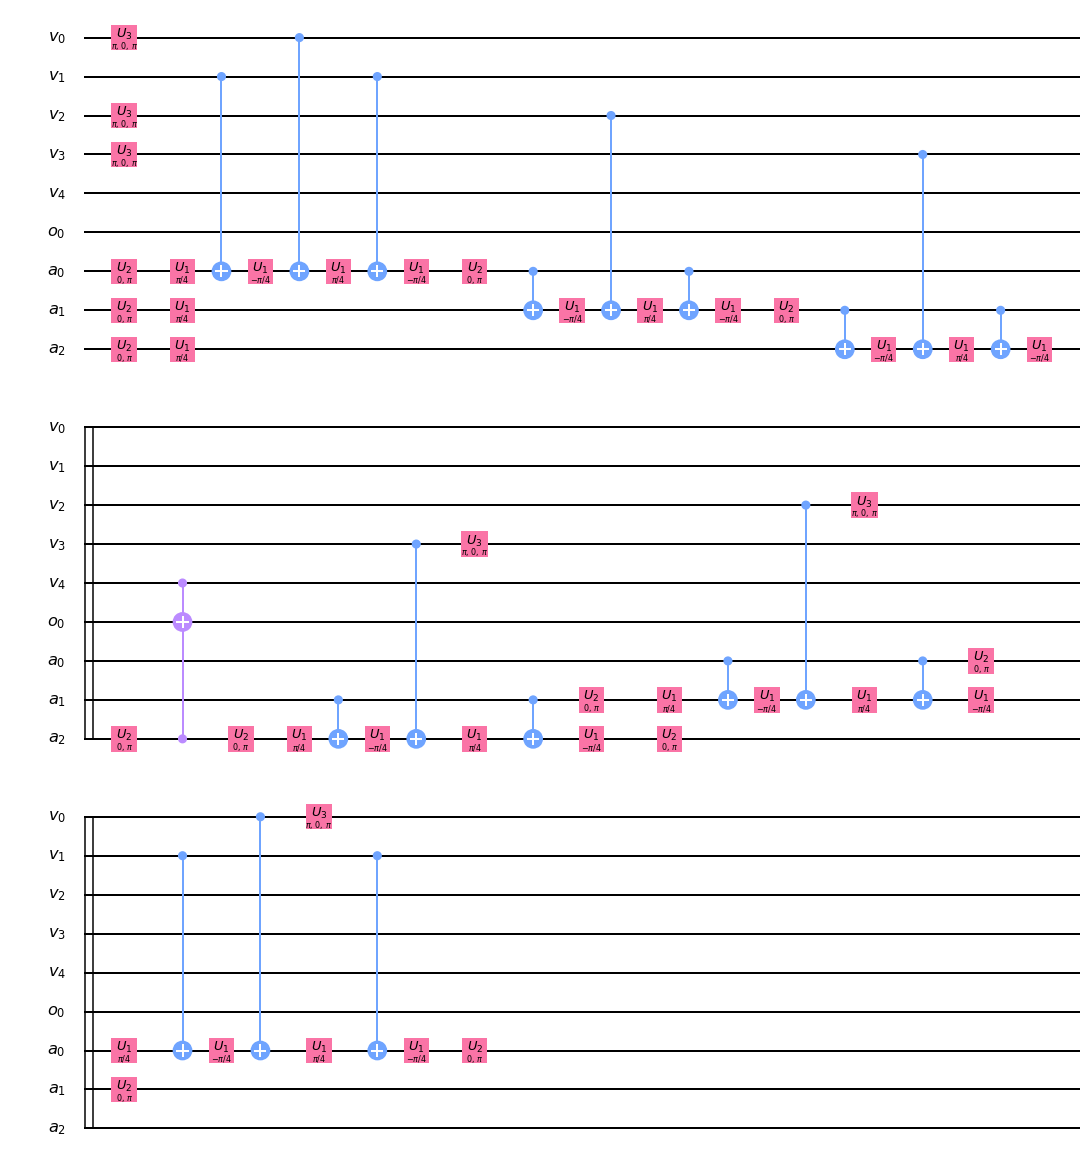

In [12]:
# Construct the Oracle Circuit with the LogicalExpressionOracle and set the optimisation parameter to True
oracle = LogicalExpressionOracle(input_3sat, optimization=True)

# Draw the circuit of oracle with the method .circuit.draw()
oracle.circuit.draw(output='mpl', scale=0.6)

In [13]:
# Create a grover instance with the Grover function 
# use the num_iterations by default = 1
grover = Grover(oracle, num_iterations=5)

In [14]:
# Load the qasm_simulator backend from Aer module
backend = Aer.get_backend('qasm_simulator')

# Create a quantum_instance with QuantumInstance
quantum_instance = QuantumInstance(backend, shots=8192)

# run the Grover algorithm on the quantum_instance
result = grover.run(quantum_instance)

# print the results of the experiment result['result'] or result['measurement']
print('The corresponding result is: ',result['result'], 'or',  result['measurement'])



The corresponding result is:  [-1, 2, -3, -4, 5] or {'01100': 36, '01011': 48, '11101': 33, '00110': 42, '00011': 30, '01110': 49, '10101': 40, '00000': 27, '01111': 50, '01001': 53, '10001': 34, '01000': 25, '00100': 38, '00001': 34, '11010': 46, '00111': 46, '11001': 30, '01010': 45, '10100': 29, '10010': 7046, '10110': 41, '00101': 27, '10111': 31, '00010': 38, '11000': 34, '01101': 35, '10011': 41, '11111': 30, '11110': 33, '11100': 36, '10000': 32, '11011': 33}


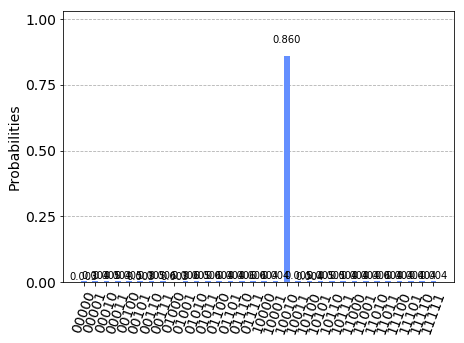

In [15]:
# plot the histogram with the plot_histogram function on result['measurement']
plot_histogram(result['measurement'])

/Users/jmt/miniconda3/envs/Q/lib/python3.7/site-packages/qiskit/aqua/qiskit_aqua.py:119: DeprecationWarning: Declarative API will be removed next Aqua release. Please construct classes and call appropriate methods.
  warnings.warn(aqua_globals.CONFIG_DEPRECATION_MSG, DeprecationWarning)


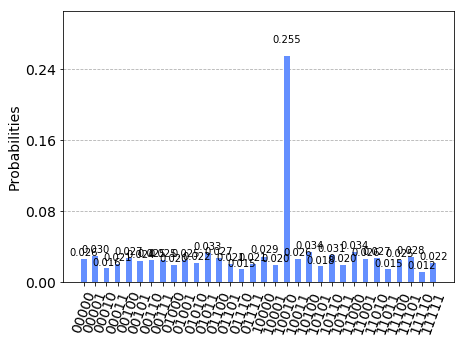

In [16]:
params = {
    'problem': {
        'name': 'search',
    },
    'algorithm': {
        'name': 'Grover',
        'num_iterations': 1
    },
    'oracle': {
        'name': 'LogicalExpressionOracle',
        'expression': input_3sat
    },
    'backend': {
        'shots': 1000,
    },
}
# Use run_algorithm function on the backend with specified params above
result_dict = run_algorithm(params, backend=backend)

# plot the histogram with the plot_histogram function on result_dict['measurement']
plot_histogram(result_dict['measurement'])

So we find 01001 a card with a letter index, red, with no sharp edge on top of the suit symbol, at even position, and in the middle values. Did you guess what card it is ? 

## Thank you for your attention

<img src="./images/merci.png" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="600 px" align="center">
<br>